# Covid-19 dynamics analysis

Прогноз, байевский вывод для экспоненциальной и сигмоидальной модели

**Автор**: Кирилл Ляхнович

In [2]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.integrate as integrate
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

### Data preparation

In [3]:
df = pd.read_csv("owid-covid-data.csv")
df = df[df.location == "Russia"]
df.date = df.date.apply(pd.to_datetime)

In [4]:
start_date = pd.to_datetime("2020-03-03")
num_days = 50
filtered_df = df[df.date >= start_date][:num_days][["date", "total_cases", "new_cases", "new_cases_smoothed"]]

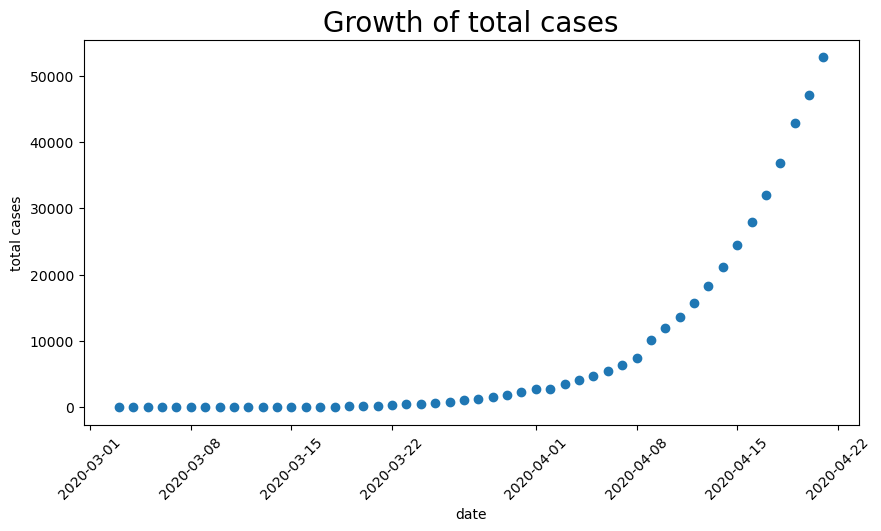

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.plot(filtered_df.set_index(filtered_df.date).total_cases, "o")
plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("total cases")
plt.title("Growth of total cases", size=20);

# Экспоненциальная модель

Рассмотрим экспоненциальную модель

$\Large \hat{y} = f(x) = e^{ax + b} $

In [252]:
import torch

class ExpModel:
    def __init__(self):
        self.params = {
            "a": torch.tensor([0.5], requires_grad=True),
            "b": torch.tensor([0.5], requires_grad=True),
        }
        
    def __call__(self, x):
        return torch.exp(self.params["a"] * x + self.params["b"])
    
    def update_params(self, lr):
        for name, param in self.params.items():
            param.data -= lr*param.grad.data
            param.grad.data = torch.zeros_like(param.grad.data)


### Обучение
**Оптимизировать будем MSE от разности логарифмов**

Можно было конечно трансофрмировать таргет логарифмом и обучать обычную линейную регрессию, но так не интересно. Поэтому лосс такой:

$$ \Large L(y,\hat{y})  = \frac{1}{N} \sum_{i}^{N}(\log{y_i} - \log{\hat{y_i}})^2 $$

In [253]:
def log_mse(y_true, y_pred):
    return torch.mean((torch.log(y_true) - torch.log(y_pred))**2)

In [589]:
x = torch.linspace(0,num_days-1, num_days)
y = torch.tensor(filtered_df.total_cases.values)
exp_model = ExpModel()

steps = 1000
lr = 1e-3
for step_id in tqdm(range(steps)):
    
    y_pred = exp_model(x)
    loss = log_mse(y,y_pred)
    loss.backward()
    
    exp_model.update_params(lr)

100%|██████████| 1000/1000 [00:00<00:00, 2538.60it/s]


### Визуализация результата

In [590]:
y_pred = exp_model(x)

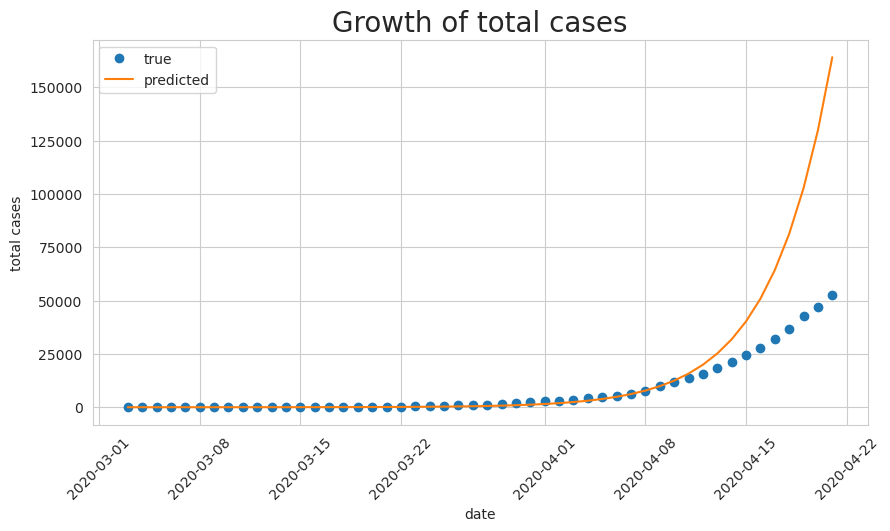

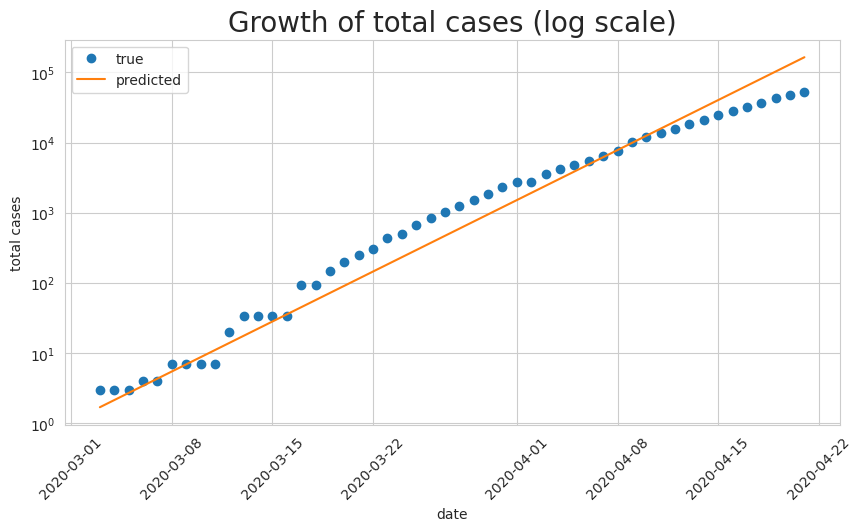

In [587]:
fig = plt.figure(figsize=(10, 5))
plt.plot(filtered_df.set_index(filtered_df.date).total_cases, "o", label = 'true')
plt.plot(pd.Series(data = y_pred.detach().numpy(), index =filtered_df.date), label = 'predicted')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("total cases")
plt.title("Growth of total cases", size=20);

fig = plt.figure(figsize=(10, 5))
plt.plot(filtered_df.set_index(filtered_df.date).total_cases, "o", label = 'true')
plt.plot(pd.Series(data = y_pred.detach().numpy(), index =filtered_df.date), label = 'predicted')
plt.legend()
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("total cases")
plt.title("Growth of total cases (log scale)", size=20);

Как видно на первом графике, дальнейшие предсказания расходятся с действительностью: рост экспоненты слишком быстрый


### Априорное распределение параметров
Пусть оба параметра имеют нормальноerrorsаспределение
$a,b \sim N(\mu, \Sigma), \quad \mu_i = \frac{1}{2}, \Sigma_{ij} = \delta_{ij}$

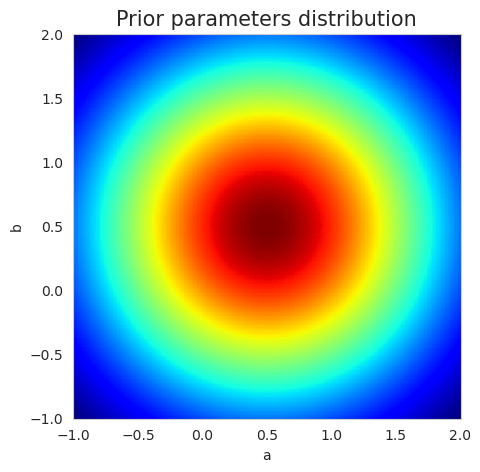

In [345]:
N = 300
xs = np.linspace(-3, 3, N)
X = np.linspace(-1, 2, N)
Y = np.linspace(-1, 2, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

cur_mu, cur_sigma = np.array([.5, .5]), np.array([[1, 0], [0, 1]])
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

plt.subplots(figsize = (5,5))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet);

plt.xlabel("a")
plt.ylabel("b")
plt.title("Prior parameters distribution", size=15);

### Распределение ошибок

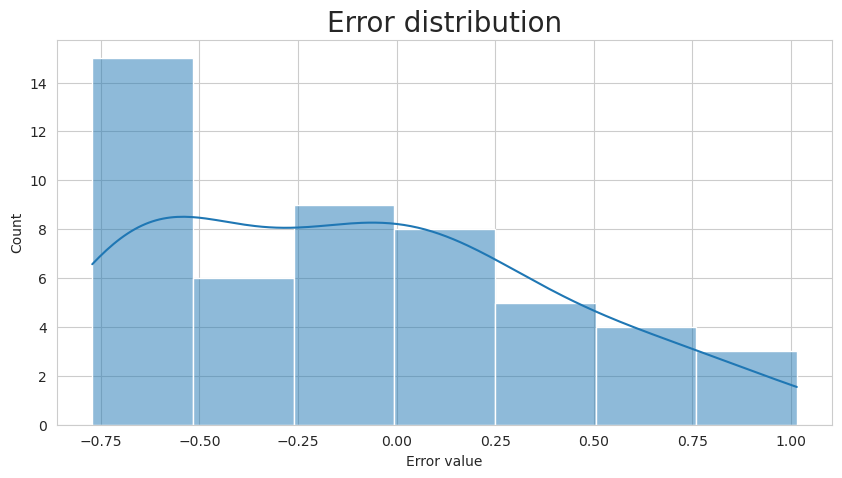

In [264]:
errors = (torch.log(y_pred) - torch.log(y)).detach().numpy()
epsilon= np.sqrt((errors**2).mean())
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlabel("Error value")
plt.title("Error distribution", size=20);
sns.histplot(errors, ax = ax, kde = True);

**Видно, что ошибки распределены не очень нормально из-за того, что экспоненциальная модель не очень подходит для описания дальнейшего поведения эпидемии. Однако если взять 30 первых точек, то ошибки будут нормальными.(Я проверял)**

## Правдоподобие

Условимся считать что ошибка **$\epsilon$** распределена нормально со среднем в нуле и с дисперсией как у ошибок, полученных выше

Тогда истинные значения распределенны как :
$$ \log y \sim N(\log \hat{y} | a, b,\quad \epsilon ^2)$$
Тогда прадоподобие выглядит как:

$$ \Large p(D|a,b) = \prod_i^N p(log y_i = log \hat{y_i}| a,b) = \prod_i^N \frac{1}{\epsilon \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{log y_i - log \hat{y_i}}{\epsilon})^2}$$
  
 

In [350]:
def likelyhood(a,b,X,y_true, epsilon):
    y_pred = np.exp(a*X + b)
    likelihoods = (1/(epsilon*np.sqrt(2*torch.pi)))*torch.exp(-0.5*((torch.log(y_true) - torch.log(y_pred))/epsilon)**2)
    return torch.prod(likelihoods).numpy()


## Графики правдоподобия и апостериорного распределения

In [504]:
N = 500
xs = np.linspace(-3, 3, N)
X = np.linspace(0.15, 0.25, N)
Y = np.linspace(0.6, 1.8, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = np.array([[ likelyhood(*pos[i, j], x,y,epsilon) for j in range(pos.shape[1])] for i in range(pos.shape[0])])


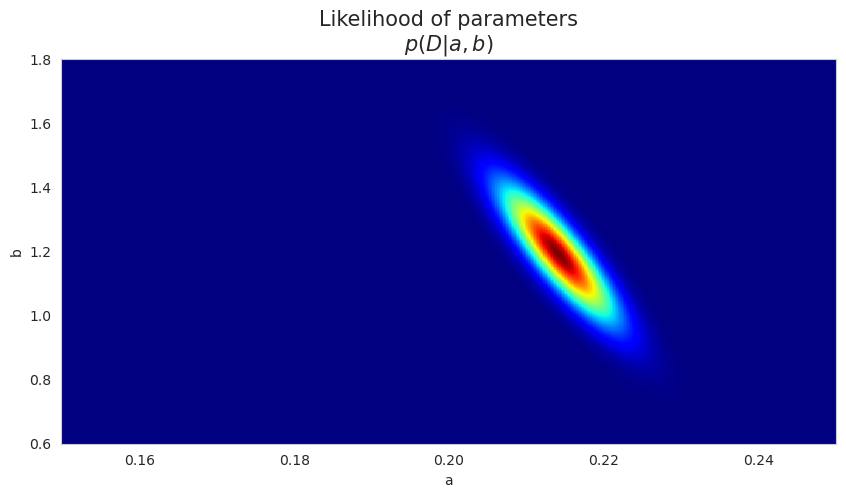

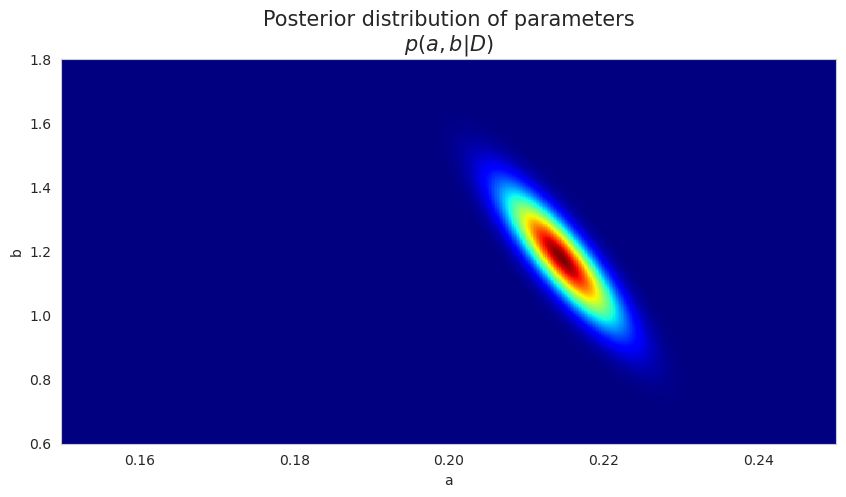

In [505]:
plt.subplots(figsize = (10,5))
plt.xlabel("a")
plt.ylabel("b")
plt.title("Likelihood of parameters\n$p(D|a,b)$", size=15);
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet);

PRIOR  = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
POSTERIOR_Z = Z * PRIOR

plt.subplots(figsize = (10,5))
plt.xlabel("a")
plt.ylabel("b")
plt.title("Posterior distribution of parameters\n$p(a,b|D)$", size=15);
plt.pcolormesh(X, Y, POSTERIOR_Z, cmap=plt.cm.jet);


На первый взгляд кажется что между правдоподобием и апостериорным распределением нет никакой разницы, но на самом деле она есть: распределение чуть-чуть сдвинулось вниз вправо - в сторону максимума плотности априорного распределения.
Изменение это не очень значительное из-за того, что точек довольно много и правдоподобие от 50 точек очень очень быстро затухает за пределами максимума.

## Сэмплирование из апостериорного распределения

Перенормируем наш грид правдоподобия и выберем оттуда несколько точек согласно их вероятностям

In [506]:
POSTERIOR_Z = POSTERIOR_Z/POSTERIOR_Z.sum()\

In [507]:
POSTERIOR_Z.sum()

0.9999999999999998

In [531]:

def sample_params(posterior_probs, N):
    sampled_params =[]
    while len(sampled_params) < N:
        random_mask = np.random.random(size =POSTERIOR_Z.shape)
        pos_mask = (POSTERIOR_Z > random_mask)
        params = pos[pos_mask]
        if len(params) > 0:
            sampled_params.append(params)
    sampled_params = np.concatenate(sampled_params)[:N]
    return sampled_params

In [532]:
N = 200
sampled_params  = sample_params(POSTERIOR_Z, N)

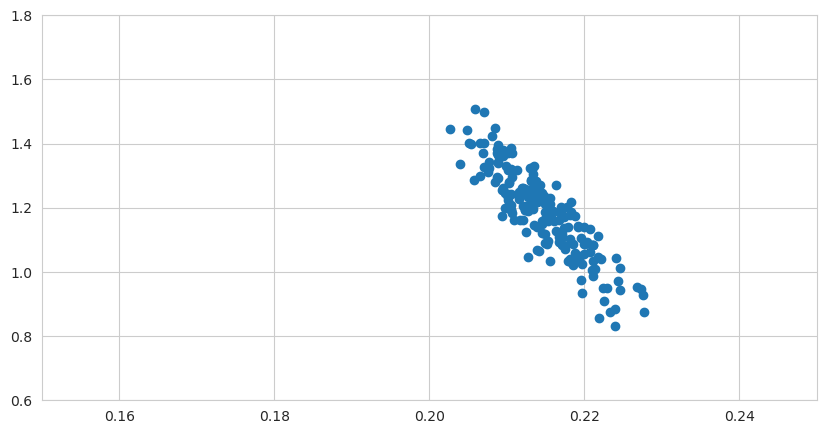

In [533]:
plt.subplots(figsize = (10,5))
plt.scatter(sampled_params.T[0],sampled_params.T[1]);
plt.axis([0.15, 0.25,0.6, 1.8,]);

## Визуализация насемплированных экспонент

In [604]:
N = 50
sampled_params  = sample_params(POSTERIOR_Z, N)

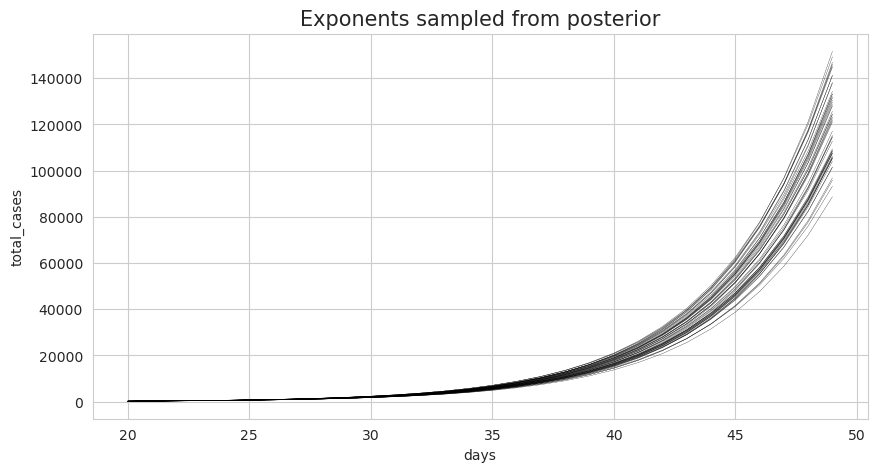

In [605]:
plt.subplots(figsize = (10,5))
ys_sampled = []
for (a,b) in sampled_params:
    y_sampled = np.exp(a*x +b)
    ys_sampled.append(y_sampled.numpy())
    plt.plot(x[20:],y_sampled[20:], 'k-', lw=.2)
ys_sampled = np.vstack(ys_sampled)

plt.xlabel("days")
plt.ylabel("total_cases")
plt.title("Exponents sampled from posterior", size=15);

## Предсказательное распределение

Предсказательное распределение построим из насемлированных экспонент. Для этого посчитаем среднее и дисперсию

In [616]:
y_sampled_mean = np.mean(ys_sampled, axis = 0)
y_sampled_sigma = np.sqrt(np.var(ys_sampled, axis =0))

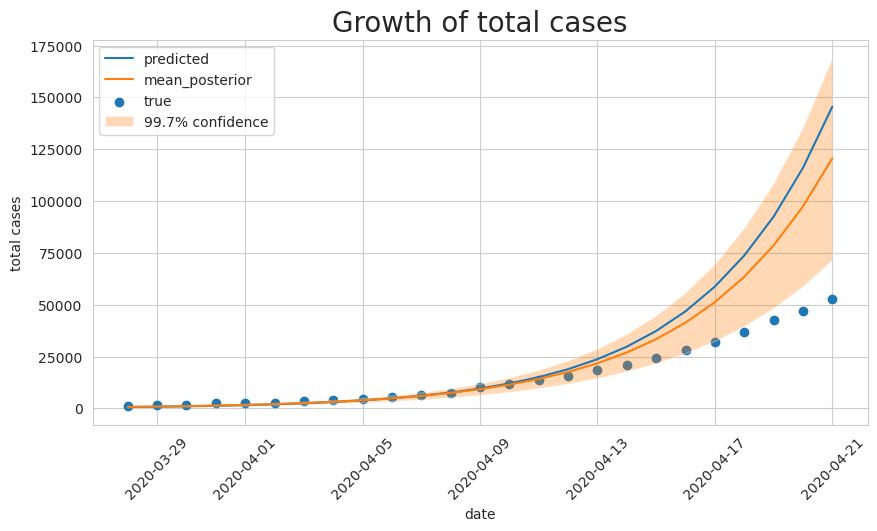

In [619]:
start_point_idx = 25
sigma_distance = 3
dates = filtered_df.date.values[start_point_idx:]

y_conf_low = y_sampled_mean -  sigma_distance*y_sampled_sigma
y_conf_up = y_sampled_mean + sigma_distance*y_sampled_sigma
y_conf_up =y_conf_up[start_point_idx:]
y_conf_low =y_conf_low[start_point_idx:]

plt.subplots(figsize = (10,5))
plt.plot(dates,y_pred.detach().numpy()[start_point_idx:],  label ='predicted')
plt.plot(dates,y_sampled_mean[start_point_idx:],  label ='mean_posterior')
plt.scatter(dates, y[start_point_idx:], label = 'true')
plt.fill_between(dates,y_conf_low,y_conf_up, alpha = 0.3, label ='99.7% confidence');


plt.legend()
#plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("total cases")
plt.title("Growth of total cases", size=20);

**С ростом аргумента эспоненциально быстро растет и доверительный интервал**

По итогу получили, что модель неплохо предсказывает изначальное развитие болезни, но на последующих этапах не соответствует действительности

In [633]:
days = (pd.to_datetime('2020-06-01')-pd.to_datetime('2020-03-03')).days
print(f'К 1 мая будет {int(exp_model(days).detach().numpy()[0])} случаев заражения')

К 1 мая будет 1590658944 случаев заражения


Такая модель предсказывает, что к маю в России заболевших будет 1.5 миллиарда случаев заражения. В то время как население России всего около 140 млн

# Сигмоидальная модель

В природе эпидемии ведут себя так: сначала экспоненциально растут, а потом экспоненциально затухают. И могут делать они такое "волнами". Одна волна по сути представляет из себя такую около-сигмоиду. Именно такую модель мы и собираемся обучить

In [145]:
start_date = pd.to_datetime("2020-03-03")
num_days = 70
num_test = 30
filtered_df = df[df.date >= start_date][["date", "total_cases", "new_cases", "new_cases_smoothed"]][:num_days + num_test]
filtered_train = filtered_df[:num_days]
filtered_test = filtered_df[num_days:num_days+num_test]

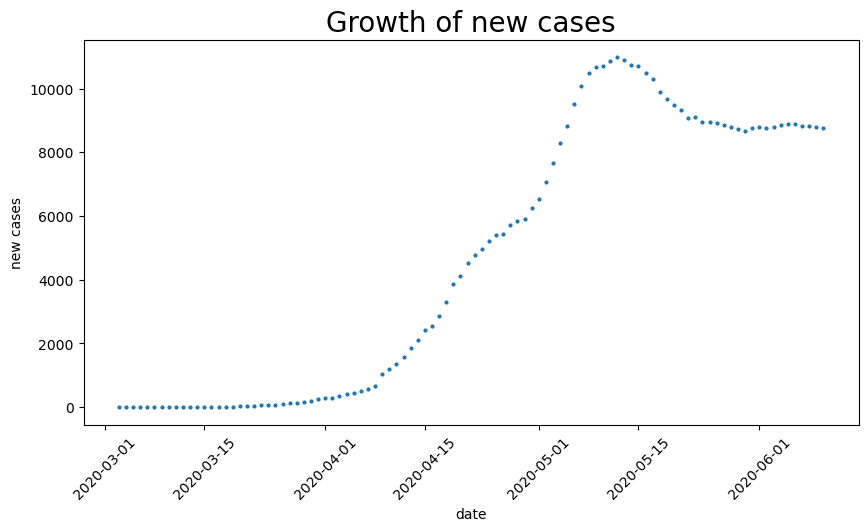

In [146]:
fig = plt.figure(figsize=(10, 5))
plt.plot(filtered_df.set_index(filtered_df.date).new_cases_smoothed, "o", markersize=2)
plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("new cases")
plt.title("Growth of new cases", size=20);

### Формулы

За сигмоиду возьмемм интеграл от гауссианы.

$$ \Large \phi(x) = c e^{-(\frac{x - a}{b})^2} $$

$$ \Large  \Phi(x) =  \int_{-\infty}^{+\infty} ce^{-(\frac{x - a}{b})^2} $$


Заметим что можно занести $c$ в показатель степени и получить параболу с 3 степенями свободы


$$ \Large \phi(x) = c e^{-(\frac{x - a}{b})^2} =  e^{-(\frac{x - a}{b})^2 + \log c}  =  e^{-\frac{x^2}{b^2} + \frac{ax}{b^2} - \frac{a^2}{b^2} + \log c}  = e^{\hat{a}x^2 + \hat{b}x + \hat{c}} $$

Тогда можно взять логарифм от колонки new_cases и обучать коэффициенты параболы обычной линейной регрессией

### Обучение

In [147]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)

In [148]:
eps = 1
x_train = np.linspace(0,num_days-1, num_days)
x_test = np.linspace(num_days, num_test + num_days, num_test)

x_train =np.vstack([x_train**2,x_train]).T
x_test =np.vstack([x_test**2,x_test]).T

y_true = filtered_train.new_cases.values
log_y_true = np.log(y_true+eps)

In [149]:
X = np.vstack([x_train,x_test])

In [150]:
lr.fit(x_train,log_y_true)

LinearRegression()

In [165]:
a,b,c = *lr.coef_, lr.intercept_
a,b,c

(-0.001983615249119415, 0.2875608835956901, -0.9419436407478008)

In [152]:
y_pred = np.exp(lr.predict(X)) - eps

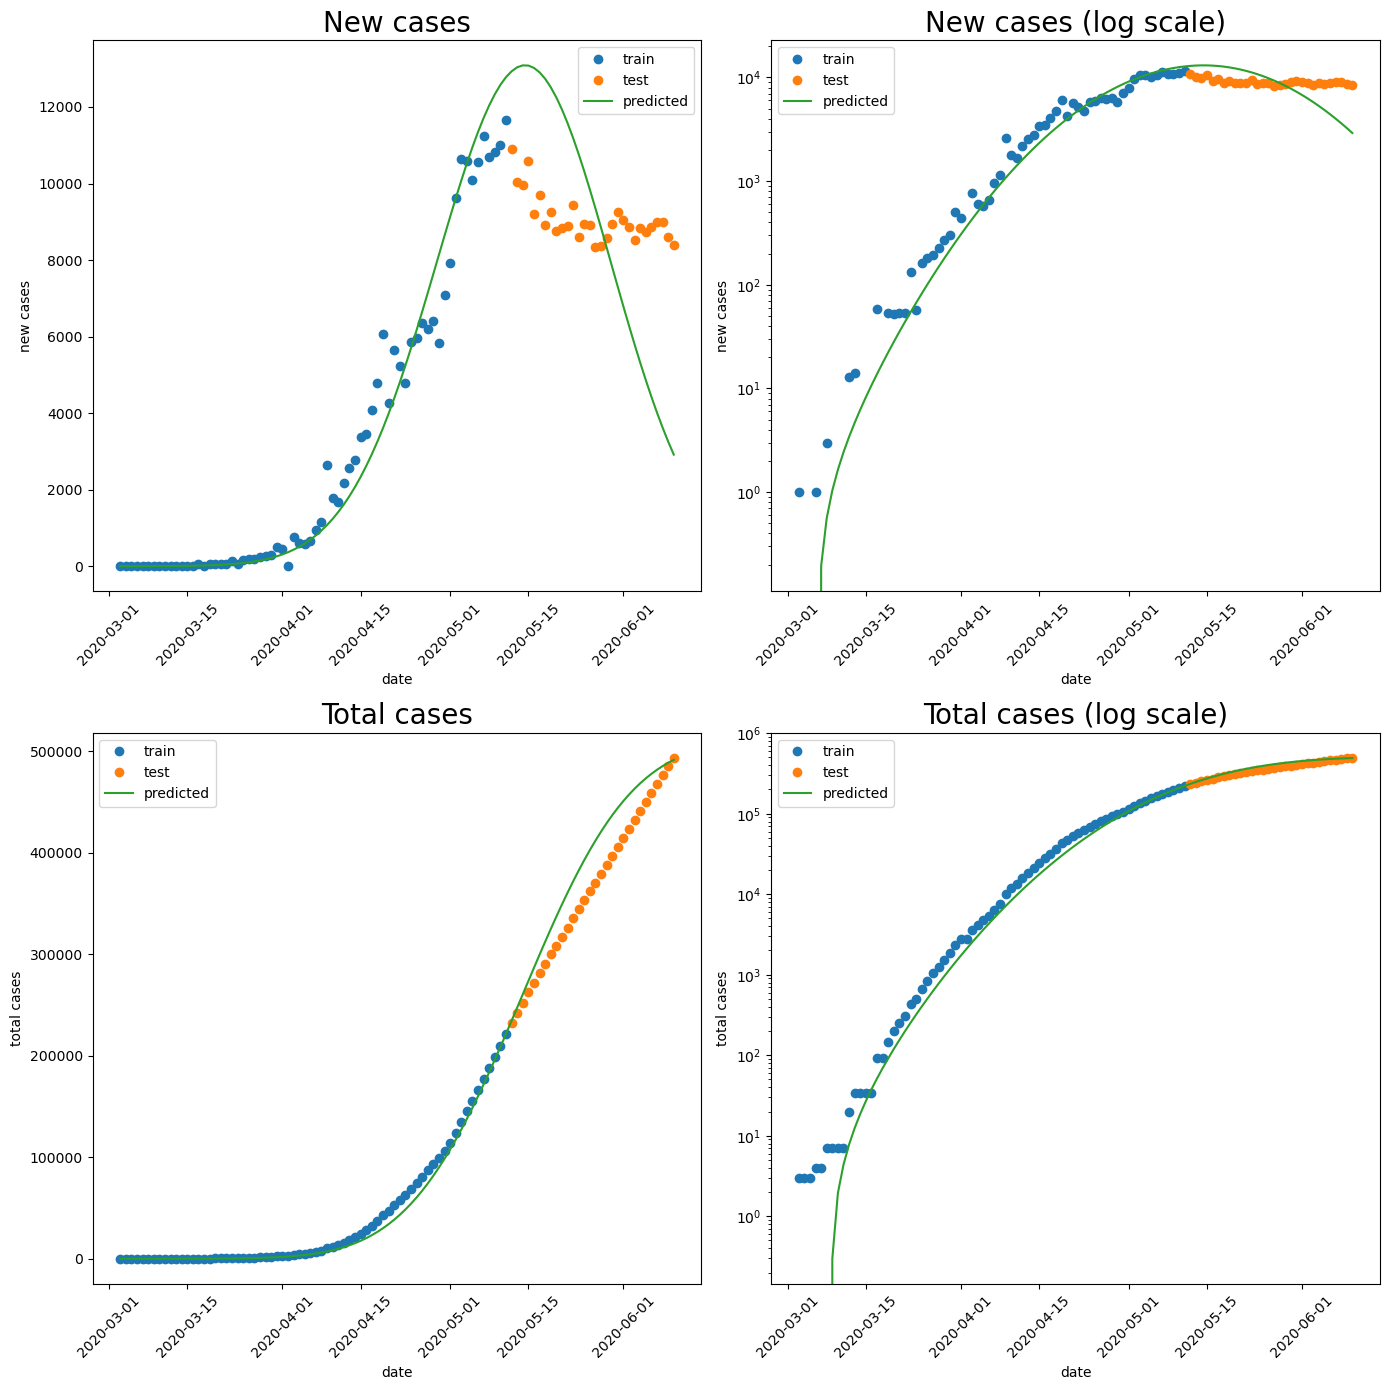

In [154]:
fig, ax = plt.subplots(2,2, figsize  = (14,14))
ax = plt.subplot(2,2,1)
ax.plot(filtered_train.set_index(filtered_train.date).new_cases, "o", label = 'train')
ax.plot(filtered_test.set_index(filtered_test.date).new_cases, "o", label = 'test')
ax.plot(filtered_df.date,y_pred, label = 'predicted')
ax.legend()
plt.xticks(rotation=45)
ax.set_xlabel("date")
ax.set_ylabel("new cases")
ax.set_title("New cases", size=20);


ax = plt.subplot(2,2,2)
ax.plot(filtered_train.set_index(filtered_train.date).new_cases, "o", label = 'train')
ax.plot(filtered_test.set_index(filtered_test.date).new_cases, "o", label = 'test')
ax.plot(filtered_df.date,y_pred, label = 'predicted')
ax.legend()
plt.xticks(rotation=45)
ax.set_xlabel("date")
ax.set_ylabel("new cases")
ax.set_yscale('log')
ax.set_title("New cases (log scale)", size=20);


ax = plt.subplot(2,2,3)
ax.plot(filtered_train.set_index(filtered_train.date).total_cases, "o", label = 'train')
ax.plot(filtered_test.set_index(filtered_test.date).total_cases, "o", label = 'test')
ax.plot(filtered_df.date,np.cumsum(y_pred), label = 'predicted')
ax.legend()
plt.xticks(rotation=45)
ax.set_xlabel("date")
ax.set_ylabel("total cases")
ax.set_title("Total cases", size=20);



ax = plt.subplot(2,2,4)
ax.plot(filtered_train.set_index(filtered_train.date).total_cases, "o", label = 'train')
ax.plot(filtered_test.set_index(filtered_test.date).total_cases, "o", label = 'test')
ax.plot(filtered_df.date,np.cumsum(y_pred), label = 'predicted')
ax.legend()
plt.xticks(rotation=45)
ax.set_xlabel("date")
ax.set_ylabel("total cases")
ax.set_yscale('log')
ax.set_title("Total cases (log scale)", size=20);


fig.tight_layout()



### Распределение ошибок

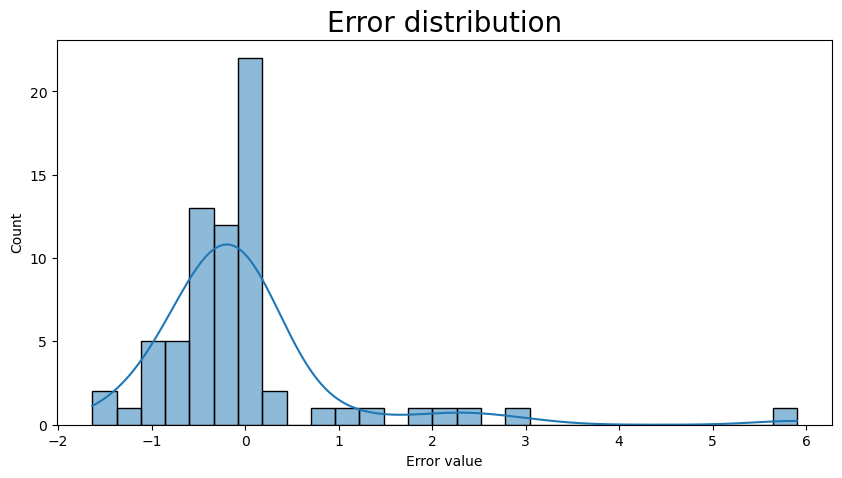

In [255]:
errors = (np.log(y_pred[:num_days]+1)- np.log(filtered_train.new_cases + 1))
epsilon= np.sqrt((errors**2).mean())
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlabel("Error value")
plt.title("Error distribution", size=20);
sns.histplot(errors, ax = ax, kde = True);

## Правдоподобие

Аналогичным образом посчитаем правдоподобие логарифма

$$\log y \sim N(\log \hat{y} | a, b,c,\quad \epsilon ^2)$$

$$ \Large p(D|a,b) = \prod_i^N p(log y_i = log \hat{y_i}| a,b,c ) = \prod_i^N \frac{1}{\epsilon \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{log y_i - log \hat{y_i}}{\epsilon})^2}$$

In [269]:
def likelyhood(a,b,c,X,y_true, epsilon):
    #y_pred = np.exp(lr.predict(X))
    y_pred = np.exp(np.dot(X,[a,b]) + c)
    likelihoods = (1/(epsilon*np.sqrt(2*np.pi)))*np.exp(-0.5*((np.log(y_true + 1)-np.log(y_pred+1))/epsilon)**2)
    return np.product(likelihoods)
